# Task A — EDA & Data Quality

Describe findings and visuals here.

In [2]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
pd.set_option('display.max_columns', 120)
plt.style.use('seaborn-v0_8')
DATA_DIR = Path('../dataset')
sup = pd.read_csv(DATA_DIR/'suppliers.csv')
prod = pd.read_csv(DATA_DIR/'products.csv')
prices = pd.read_csv(DATA_DIR/'price_lists.csv', parse_dates=['valid_from','valid_to'])
po = pd.read_csv(DATA_DIR/'purchase_orders.csv', parse_dates=['order_date','promised_date'])
deliv = pd.read_csv(DATA_DIR/'deliveries.csv', parse_dates=['actual_delivery_date'])
po = po.merge(deliv, on='order_id', how='left')
print(sup.shape, prod.shape, prices.shape, po.shape)


(20, 7) (40, 5) (854, 7) (4307, 20)


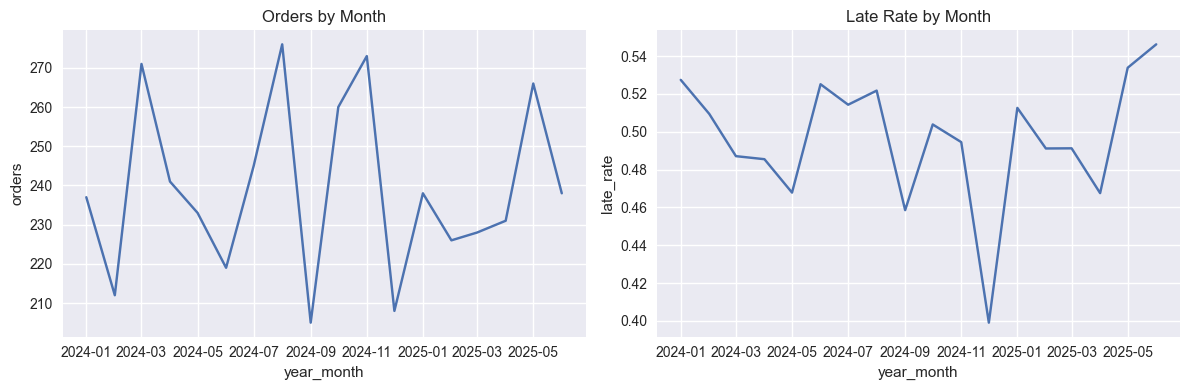

In [3]:

po['year_month'] = po['order_date'].dt.to_period('M').dt.to_timestamp()
late = po.query('cancelled == 0').assign(late_delivery=lambda d: d['late_delivery'].fillna(0).astype(int))
monthly = late.groupby('year_month').agg(orders=('order_id','count'), late_rate=('late_delivery','mean')).reset_index()
fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(data=monthly, x='year_month', y='orders', ax=ax[0]); ax[0].set_title('Orders by Month')
sns.lineplot(data=monthly, x='year_month', y='late_rate', ax=ax[1]); ax[1].set_title('Late Rate by Month')
plt.tight_layout(); plt.show()


In [4]:
def pct(x): 
    return f"{100*x:.1f}%"

print("Is supplier_id unique? ", sup['supplier_id'].is_unique)
print("Is sku unique? ", prod['sku'].is_unique)

duplicate_prices = prices.duplicated(subset=['supplier_id','sku','valid_from','valid_to']).sum()
print("Duplicate prices:", duplicate_prices)

po_sup = po.merge(sup[['supplier_id']], on='supplier_id', how='left', indicator=True)
sup_cov = (po_sup['_merge'] == 'both').mean()
print("Coverage to suppliers:", pct(sup_cov))

po_prod = po.merge(prod[['sku']], on='sku', how='left', indicator=True)
prod_cov = (po_prod['_merge'] == 'both').mean()
print("Coverage to products:", pct(prod_cov))

missing = po.isna().mean().sort_values(ascending=False)
print("\nMissingness in purchase_orders:")
print(missing.head(15))

if 'promised_date' in po.columns and 'order_date' in po.columns:
    bad_promised = (po['promised_date'] < po['order_date']).sum()
    print("promised_date < order_date:", bad_promised)

if 'actual_delivery_date' in po.columns and 'order_date' in po.columns:
    bad_actual = (po['actual_delivery_date'] < po['order_date']).sum()
    print("actual_delivery_date < order_date:", bad_actual)

for col in ['qty','unit_price']:
    if col in po.columns:
        neg = (po[col] < 0).sum()
        zero = (po[col] == 0).sum()
        print(f"{col}: negatives={neg}, zeros={zero}")


Is supplier_id unique?  True
Is sku unique?  True
Duplicate prices: 0
Coverage to suppliers: 100.0%
Coverage to products: 100.0%

Missingness in purchase_orders:
order_notes             0.900395
order_id                0.000000
promised_date           0.000000
delay_reason            0.000000
cancelled               0.000000
partial_delivery        0.000000
delay_days              0.000000
late_delivery           0.000000
actual_delivery_date    0.000000
urgent                  0.000000
distance_km             0.000000
order_date              0.000000
payment_terms           0.000000
incoterm                0.000000
ship_mode               0.000000
dtype: float64
promised_date < order_date: 0
actual_delivery_date < order_date: 1
qty: negatives=0, zeros=0
unit_price: negatives=0, zeros=0


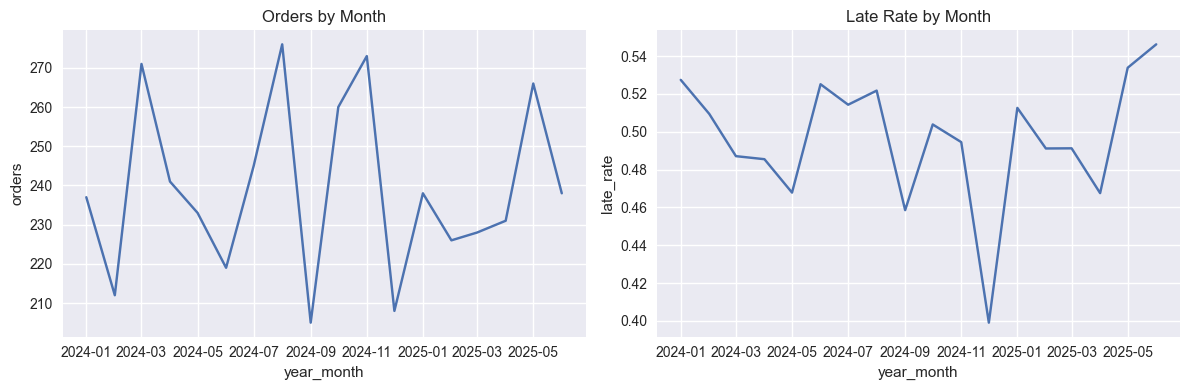

,supplier_id,orders,late_rate
10,11,191,0.638743
3,4,203,0.581281
17,18,200,0.540000
7,8,208,0.538462
5,6,225,0.537778
13,14,211,0.526066
12,13,229,0.519651
2,3,214,0.504673
15,16,222,0.500000
4,5,228,0.495614


,country,orders,late_rate
8,UK,191,0.638743
3,FR,208,0.538462
0,CN,440,0.534091
1,CZ,415,0.508434
4,IN,636,0.496855
2,DE,218,0.490826
5,IT,672,0.489583
7,PL,865,0.475145
6,NL,443,0.469526
9,US,219,0.424658


,ship_mode,orders,late_rate
3,sea,820,0.623171
1,rail,223,0.520179
2,road,2594,0.479568
0,air,670,0.407463


/var/folders/y0/nw305xy1131327ks861hhdbr0000gp/T/ipykernel_39773/1301429485.py:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dist_slice = (val.groupby('distance_band')


,distance_band,orders,late_rate
0,<=500km,779,0.392811
1,500-1000km,3153,0.509356
2,1000-1500km,374,0.617647
3,1500-2000km,1,1.000000
4,>200km,0,NaN


In [5]:
work = po.copy()
work['year_month'] = work['order_date'].dt.to_period('M').dt.to_timestamp()
work = work.assign(
    cancelled = work['cancelled'].fillna(0).astype(int),
    late_delivery = (work['actual_delivery_date'] > work['promised_date']).astype(int)
)
val = work.query("cancelled == 0")

monthly = val.groupby('year_month').agg(
    orders=('order_id','count'),
    late_rate=('late_delivery','mean')
).reset_index()

fig, ax = plt.subplots(1,2, figsize=(12,4))
sns.lineplot(data=monthly, x='year_month', y='orders', ax=ax[0]); ax[0].set_title('Orders by Month')
sns.lineplot(data=monthly, x='year_month', y='late_rate', ax=ax[1]); ax[1].set_title('Late Rate by Month')
plt.tight_layout(); plt.show()

if 'supplier_id' in val.columns:
    sup_slice = (val.groupby('supplier_id')
                 .agg(orders=('order_id','count'), late_rate=('late_delivery','mean'))
                 .reset_index().sort_values('late_rate', ascending=False))
    display(sup_slice.head(10))

if 'country' in sup.columns:
    val = val.merge(sup[['supplier_id','country']], on='supplier_id', how='left')
    country_slice = (val.groupby('country')
                     .agg(orders=('order_id','count'), late_rate=('late_delivery','mean'))
                     .reset_index().sort_values('late_rate', ascending=False))
    display(country_slice.head(10))

if 'ship_mode' in val.columns:
    ship_slice = (val.groupby('ship_mode')
                  .agg(orders=('order_id','count'), late_rate=('late_delivery','mean'))
                  .reset_index().sort_values('late_rate', ascending=False))
    display(ship_slice)

if 'distance_km' in val.columns:
    bins = [-np.inf, 500, 1000, 1500, 2000, np.inf]
    labels = ['<=500km','500-1000km','1000-1500km','1500-2000km', '>200km']
    val['distance_band'] = pd.cut(val['distance_km'], bins=bins, labels=labels)
    dist_slice = (val.groupby('distance_band')
                  .agg(orders=('order_id','count'), late_rate=('late_delivery','mean'))
                  .reset_index())
    display(dist_slice)


/var/folders/y0/nw305xy1131327ks861hhdbr0000gp/T/ipykernel_39773/4001761173.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=country_plot, x='late_rate', y='country', palette='viridis')


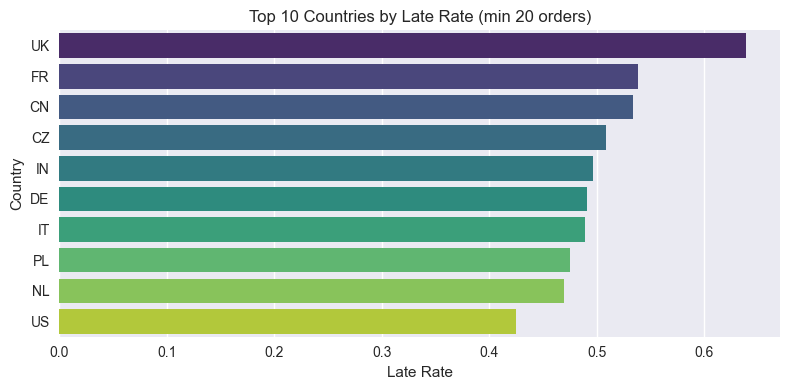

/var/folders/y0/nw305xy1131327ks861hhdbr0000gp/T/ipykernel_39773/4001761173.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ship_plot, x='ship_mode', y='late_rate', palette='magma')


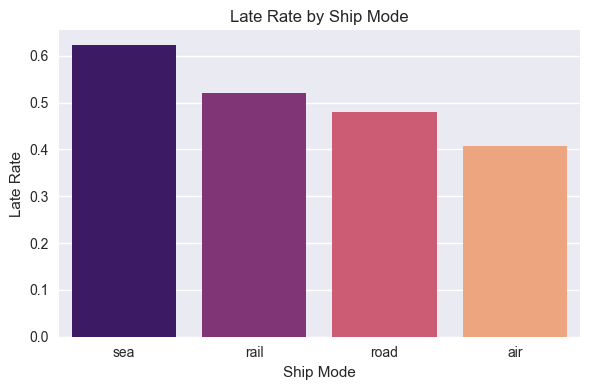

/var/folders/y0/nw305xy1131327ks861hhdbr0000gp/T/ipykernel_39773/4001761173.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=dist_plot, x='distance_band', y='late_rate', palette='coolwarm')


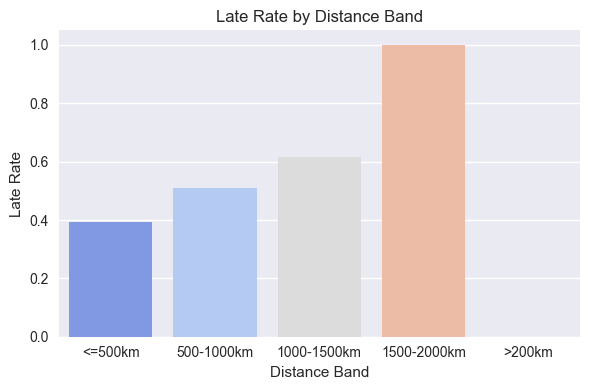

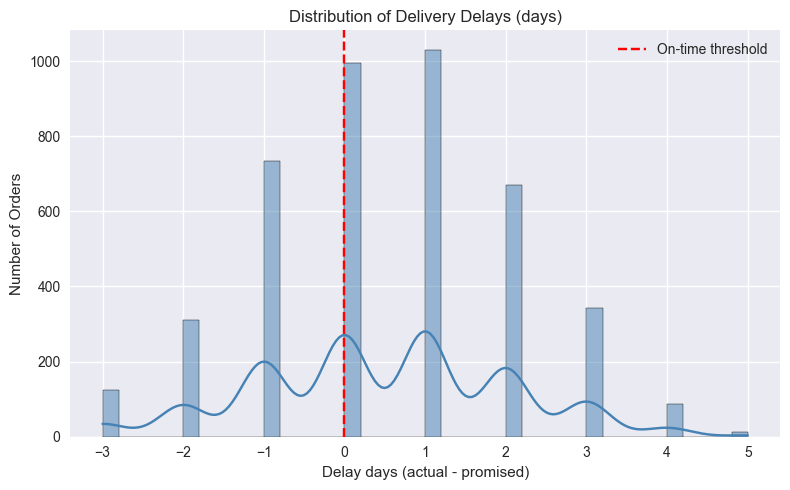

In [6]:
if 'country' in val.columns:
    country_plot = (val.groupby('country')
                    .agg(orders=('order_id','count'), late_rate=('late_delivery','mean'))
                    .reset_index().query("orders >= 20")
                    .sort_values('late_rate', ascending=False).head(10))
    plt.figure(figsize=(8,4))
    sns.barplot(data=country_plot, x='late_rate', y='country', palette='viridis')
    plt.title('Top 10 Countries by Late Rate (min 20 orders)')
    plt.xlabel('Late Rate'); plt.ylabel('Country')
    plt.tight_layout()
    plt.show()

if 'ship_mode' in val.columns:
    ship_plot = (val.groupby('ship_mode')
                 .agg(orders=('order_id','count'), late_rate=('late_delivery','mean'))
                 .reset_index().sort_values('late_rate', ascending=False))
    plt.figure(figsize=(6,4))
    sns.barplot(data=ship_plot, x='ship_mode', y='late_rate', palette='magma')
    plt.title('Late Rate by Ship Mode')
    plt.ylabel('Late Rate'); plt.xlabel('Ship Mode')
    plt.tight_layout()
    plt.show()

if 'distance_band' in val.columns:
    dist_plot = dist_slice.dropna(subset=['late_rate'])
    plt.figure(figsize=(6,4))
    sns.barplot(data=dist_plot, x='distance_band', y='late_rate', palette='coolwarm')
    plt.title('Late Rate by Distance Band')
    plt.ylabel('Late Rate'); plt.xlabel('Distance Band')
    plt.tight_layout()
    plt.show()


delivered = val[val['actual_delivery_date'].notna()].copy()
delivered['delay_days'] = (delivered['actual_delivery_date'] - delivered['promised_date']).dt.days

plt.figure(figsize=(8,5))
sns.histplot(delivered['delay_days'], bins=40, kde=True, color='steelblue')
plt.axvline(0, color='red', linestyle='--', label='On-time threshold')
plt.title('Distribution of Delivery Delays (days)')
plt.xlabel('Delay days (actual - promised)')
plt.ylabel('Number of Orders')
plt.legend()
plt.tight_layout()
plt.show()

